In [61]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from matplotlib import pyplot

covid_data = pd.read_csv('COVID.csv')



C:\Users\gadtardi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# overviewing of data

In [30]:
covid_data.head()

,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,Race and ethnicity (combined),hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
1,2020/06/30,NaN,NaN,Probable Case,Other,0 - 9 Years,Unknown,Unknown,Unknown,No,Unknown
2,2020/07/05,NaN,NaN,Laboratory-confirmed case,Other,0 - 9 Years,Unknown,Missing,Missing,Missing,Missing
3,2020/06/10,NaN,2020/03/27,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown
4,2020/07/13,NaN,2020/04/20,Probable Case,Other,0 - 9 Years,Unknown,No,Unknown,No,Unknown


data info

In [31]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760066 entries, 0 to 5760065
Data columns (total 11 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   cdc_report_dt                  object
 1   pos_spec_dt                    object
 2   onset_dt                       object
 3   current_status                 object
 4   sex                            object
 5   age_group                      object
 6   Race and ethnicity (combined)  object
 7   hosp_yn                        object
 8   icu_yn                         object
 9   death_yn                       object
 10  medcond_yn                     object
dtypes: object(11)
memory usage: 483.4+ MB


# remove unused columns

In [32]:
covid_data = covid_data.drop([covid_data.columns[0], covid_data.columns[1],covid_data.columns[2],covid_data.columns[6]], axis = 1)
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760066 entries, 0 to 5760065
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   current_status  object
 1   sex             object
 2   age_group       object
 3   hosp_yn         object
 4   icu_yn          object
 5   death_yn        object
 6   medcond_yn      object
dtypes: object(7)
memory usage: 307.6+ MB


# remove missings

In [33]:
nullcount = covid_data.isna().sum()
print(nullcount.sort_values())

current_status     0
hosp_yn            0
icu_yn             0
death_yn           0
medcond_yn         0
sex               15
age_group         92
dtype: int64


In [34]:
covid_data = covid_data.dropna()
nullcount = covid_data.isna().sum()
print(nullcount.sort_values())

current_status    0
sex               0
age_group         0
hosp_yn           0
icu_yn            0
death_yn          0
medcond_yn        0
dtype: int64


In [35]:
covid_data.describe()

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn
count,5759974,5759974,5759974,5759974,5759974,5759974,5759974
unique,2,5,10,4,4,4,4
top,Laboratory-confirmed case,Female,20 - 29 Years,No,Missing,No,Missing
freq,5462695,2964314,1127849,2549617,4153317,2662911,3976470


# checking unique values

In [36]:
covid_data.current_status.unique()

array(['Probable Case', 'Laboratory-confirmed case'], dtype=object)

In [37]:
covid_data.sex.unique()

array(['Other', 'Male', 'Missing', 'Unknown', 'Female'], dtype=object)

In [38]:
covid_data.age_group.unique()

array(['0 - 9 Years', '10 - 19 Years', '20 - 29 Years', '30 - 39 Years',
       '40 - 49 Years', '50 - 59 Years', '60 - 69 Years', '70 - 79 Years',
       '80+ Years', 'Unknown'], dtype=object)

In [39]:
covid_data.hosp_yn.unique()

array(['Unknown', 'Missing', 'No', 'Yes'], dtype=object)

In [40]:
covid_data.icu_yn.unique()

array(['Unknown', 'Missing', 'No', 'Yes'], dtype=object)

In [41]:
covid_data.death_yn.unique()

array(['No', 'Missing', 'Unknown', 'Yes'], dtype=object)

In [42]:
covid_data.medcond_yn.unique()

array(['Unknown', 'Missing', 'Yes', 'No'], dtype=object)

# removal of 'missing' and 'unknown' values

In [43]:
covid_data['death_yn'].value_counts()

No         2662911
Missing    2321772
Unknown     617045
Yes         158246
Name: death_yn, dtype: int64

In [44]:
values1 = ['Missing', 'Unknown']

covid_data = covid_data[covid_data.death_yn.isin(values1) == False]
covid_data['death_yn'].value_counts()

No     2662911
Yes     158246
Name: death_yn, dtype: int64

In [45]:

covid_data = covid_data[(covid_data != 'Unknown').all(axis=1)]
covid_data = covid_data[(covid_data != 'Missing').all(axis=1)]
covid_data = covid_data[(covid_data != 'Other').all(axis=1)]
covid_data.sex.unique()

array(['Male', 'Female'], dtype=object)

In [46]:
covid_data.describe()

,current_status,sex,age_group,hosp_yn,icu_yn,death_yn,medcond_yn
count,411800,411800,411800,411800,411800,411800,411800
unique,2,2,9,2,2,2,2
top,Laboratory-confirmed case,Female,20 - 29 Years,No,No,No,Yes
freq,395357,216821,74196,331002,382257,381621,217580


# category encoding

In [47]:
# current status
# not forgetting to separate input and output

covid_data = covid_data.replace({'current_status': {'Laboratory-confirmed case': 1,'Probable Case': 0}})
covid_data = covid_data.replace({'sex': {'Male': 1,'Female': 0}})
covid_data = covid_data.replace({'hosp_yn': {'Yes': 1,'No': 0}})
covid_data = covid_data.replace({'icu_yn': {'Yes': 1,'No': 0}})
covid_data = covid_data.replace({'medcond_yn': {'Yes': 1,'No': 0}})


covid_data = covid_data.replace({'age_group': {'0 - 9 Years': 0,'10 - 19 Years': 1,'20 - 29 Years': 2,'30 - 39 Years': 3,'40 - 49 Years': 4,'50 - 59 Years': 5,'60 - 69 Years': 6,'70 - 79 Years': 7,'80+ Years': 8}})

covid_data['death_yn'].value_counts()                            




No     381621
Yes     30179
Name: death_yn, dtype: int64

# separating input and output sets

In [48]:
covid_data.head

<bound method NDFrame.head of          current_status  sex  age_group  hosp_yn  icu_yn death_yn  medcond_yn
164                   1    1          0        0       0       No           0
222                   1    1          0        0       0       No           0
237                   1    1          0        0       0       No           0
239                   1    1          0        0       0       No           0
251                   1    1          0        0       0       No           0
...                 ...  ...        ...      ...     ...      ...         ...
5760008               1    0          7        0       0       No           1
5760024               1    0          7        0       0       No           1
5760025               1    0          7        0       0       No           0
5760036               1    1          7        1       0       No           0
5760063               1    0          7        1       0      Yes           1

[411800 rows x 7 columns]>

In [49]:
covid_data.describe()

,current_status,sex,age_group,hosp_yn,icu_yn,medcond_yn
count,411800.000000,411800.000000,411800.000000,411800.000000,411800.000000,411800.000000
mean,0.960070,0.473480,3.987351,0.196207,0.071741,0.528363
std,0.195794,0.499297,2.105956,0.397127,0.258059,0.499195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,6.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000


In [50]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411800 entries, 164 to 5760063
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   current_status  411800 non-null  int64 
 1   sex             411800 non-null  int64 
 2   age_group       411800 non-null  int64 
 3   hosp_yn         411800 non-null  int64 
 4   icu_yn          411800 non-null  int64 
 5   death_yn        411800 non-null  object
 6   medcond_yn      411800 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 25.1+ MB


In [51]:
X = covid_data.drop(columns=['death_yn'])
y = covid_data['death_yn']
y

164         No
222         No
237         No
239         No
251         No
          ... 
5760008     No
5760024     No
5760025     No
5760036     No
5760063    Yes
Name: death_yn, Length: 411800, dtype: object

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411800 entries, 164 to 5760063
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   current_status  411800 non-null  int64
 1   sex             411800 non-null  int64
 2   age_group       411800 non-null  int64
 3   hosp_yn         411800 non-null  int64
 4   icu_yn          411800 non-null  int64
 5   medcond_yn      411800 non-null  int64
dtypes: int64(6)
memory usage: 22.0 MB


# making the model

In [53]:
model = DecisionTreeClassifier()
model.fit(X,y)
predictions1 = model.predict([[1,1,2,1,1,1]])
predictions1

array(['No'], dtype=object)

In [54]:
predictions2 = model.predict([[1,1,2,1,1,1],[1,1,5,1,1,1]])
predictions2

array(['No', 'Yes'], dtype=object)

# splitting between training and testing sets and using sklearn's accuracy_score library function to test accuracy

In [55]:
# (input sets for train/testing) (output sets for train/testing)
# reserving a randomized 20% of the data for testing, the rest for training every time run if test_size=0.2
#test for over/underfitting?

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
model.fit(X_train,y_train)
predictions3 = model.predict(X_test)

score = accuracy_score(y_test, predictions3)
score

#joblib.dump(model, 'COVID_SurvivalModel_0_2.joblib')

#tree.export_graphviz(model, out_file='COVID_SurvivalModel_0_2.dot',
                    # feature_names=['current_status','sex','age_group','hosp_yn','icu_yn','medcond_yn' ],
                   # class_names=y.unique(),
                   # label='all',
                   # rounded=True,
                  #  filled=True)



0.9431155900922779

# K-fold cross validation (10 and 100 folds to check)

In [64]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

Accuracy: 0.944 (0.001)


In [65]:
cv = KFold(n_splits=100, random_state=1, shuffle=True)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores))) 

Accuracy: 0.944 (0.004)


the results of the k-fold cross validation show a consistent and relatively low bias (0.944) that is also similar to the results of the singular accuracy_score test. Variance (standard deviation) also remains very low despite changes in k-folds tested indicating our model is likely to be very accurate and not overfitted/underfitted.

# feature Importance

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411800 entries, 164 to 5760063
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   current_status  411800 non-null  int64
 1   sex             411800 non-null  int64
 2   age_group       411800 non-null  int64
 3   hosp_yn         411800 non-null  int64
 4   icu_yn          411800 non-null  int64
 5   medcond_yn      411800 non-null  int64
dtypes: int64(6)
memory usage: 22.0 MB


In [59]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.00093
Feature: 1, Score: 0.00533
Feature: 2, Score: 0.26664
Feature: 3, Score: 0.06276
Feature: 4, Score: 0.64761
Feature: 5, Score: 0.01673


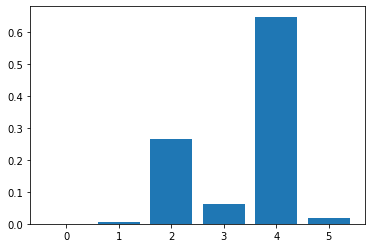

In [62]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()